In [2]:
import os

os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

In [3]:
import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow
from bizdays import Calendar, set_option

import brasa

man = brasa.engine.CacheManager()

In [4]:
set_option("mode.datetype", "datetime")
set_option("mode", "python")

cal = Calendar.load("ANBIMA")

In [40]:
db_folder_path = man.cache_path(man.db_folder())
tb_cotahist = ds.dataset(f"{db_folder_path}\\b3-cotahist\\", format="parquet")\
        .filter(pc.field("instrument_market") == 10)\
        .filter(pc.field("bdi_code") == 14)\
        .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CTF"])))\
        .filter(pc.starts_with(pc.field("specification_code"), "CI"))\
        .scanner(columns=["refdate", "symbol", "open", "high", "low", "close", "volume", "trade_quantity", "traded_contracts", "distribution_id"])\
        .to_table()
tb_cotahist.group_by("symbol").aggregate([([], "count_all")]).sort_by([("count_all", "descending")]).to_pandas().head(20)

,symbol,count_all
0,FNAM11,5244
1,FNOR11,5019
2,PIBB11,4590
3,BOVA11,3511
4,SMAL11,3393
5,FSRF11,3129
6,BRAX11,2776
7,DIVO11,2727
8,GOVE11,2664
9,FIND11,2653


In [41]:
tb_equities = ds.dataset(f"{db_folder_path}\\b3-cotahist\\", format="parquet")\
    .filter(pc.field("instrument_market") == 10)\
    .filter(pc.utf8_length(pc.field("isin")) == 12)\
    .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CDA", "UNT", "ACN"])))\
    .scanner(columns=["refdate", "symbol", "isin", "open", "high", "low", "close", "volume", "trade_quantity", "traded_contracts", "distribution_id"])\
    .to_table()
tb_equities

pyarrow.Table
refdate: timestamp[us]
symbol: string
isin: string
open: double
high: double
low: double
close: double
volume: double
trade_quantity: int64
traded_contracts: int64
distribution_id: int64
----
refdate: [[1994-01-03 00:00:00.000000,1994-01-03 00:00:00.000000,1994-01-03 00:00:00.000000,1994-01-03 00:00:00.000000,1994-01-03 00:00:00.000000,...,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000],[1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,1994-04-08 00:00:00.000000,...,1994-07-22 00:00:00.000000,1994-07-22 00:00:00.000000,1994-07-22 00:00:00.000000,1994-07-22 00:00:00.000000,1994-07-22 00:00:00.000000],...,[2023-06-26 00:00:00.000000,2023-06-26 00:00:00.000000,2023-06-26 00:00:00.000000,2023-06-26 00:00:00.000000,2023-06-26 00:00:00.000000,...,2023-06-26 00:00:00.000000,2023-06-26 00:00:00.000000,2023-06-26 00:00:00.000000,2023-06

In [43]:
tb_cotahist = ds.dataset(f"{db_folder_path}\\b3-cotahist\\", format="parquet")\
        .filter(pc.field("instrument_market") == 10)\
        .filter(pc.is_in(pc.field("bdi_code"), pyarrow.array([5, 12])))\
        .filter(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9) == "CTF")\
        .scanner(columns=["refdate", "symbol", "open", "high", "low", "close", "volume", "trade_quantity", "traded_contracts", "distribution_id"])\
        .to_table()
tb_cotahist.group_by("symbol").aggregate([([], "count_all")]).sort_by([("count_all", "descending")]).to_pandas().head(20)

,symbol,count_all
0,BBFI11B,4242
1,EURO11,4009
2,FLMA11,3981
3,FAMB11B,3754
4,HGBS11,3458
5,HGRE11,3353
6,SHPH11,3329
7,FPAB11,3270
8,PQDP11,3252
9,ABCP11,3142


<Axes: xlabel='refdate', ylabel='close'>

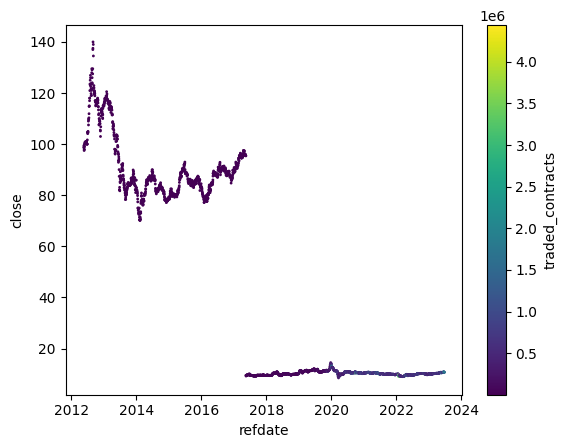

In [58]:
tb_cotahist.filter(pc.field("symbol") == "MXRF11").sort_by("refdate").to_pandas().plot.scatter(x="refdate", y="close", c="traded_contracts", colormap="viridis", s=1)